In [3]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from bellotti_r_master_thesis.isodar_scan_helper_functions import AdjustedRSquared
from bellotti_r_master_thesis.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from bellotti_r_master_thesis.invertible_network.invertible_neural_network import InvertibleNetworkSurrogate

In [4]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Config

In [5]:
datafile = '/data/user/boiger_r/invertible_network_paper_data/data_sonali/samples_5000_short.hdf5'

In [6]:
model_name = 'isodar_invertible_model2'
val_model_name = 'isodar_forward_model'

In [7]:
model_dir = '/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar/models'

In [8]:
plot_dir = '/data/user/boiger_r/invertible_network_paper_results5000/models_30_11_2020/isodar/invertible_model2/plots/model'

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [9]:
dvars = ['pr0','r0','rfphi','sigmax','sigmay','sigmaz']
qois = ['Number of Macro Particles', 'Mean Bunch Energy', 'RMS Beamsize in x',
       'RMS Beamsize in y', 'RMS Beamsize in s', 'Halo in x', 'Halo in y',
       'Halo in z', 'Normalized Emittance x', 'Normalized Emittance y',
       'Normalized Emittance s', 'energy spread of the beam','particle_losses']
qoi_labels = {'Number of Macro Particles':r'$N_{MP}$', 'Mean Bunch Energy':r'$E$', 'RMS Beamsize in x':r'$\sigma_x$',
       'RMS Beamsize in y':r'$\sigma_y$', 'RMS Beamsize in s':r'$\sigma_z$', 'Halo in x':r'$h_x$', 'Halo in y':r'$h_y$',
       'Halo in z':r'$h_z$', 'Normalized Emittance x':r'$\epsilon_x$', 'Normalized Emittance y':r'$\epsilon_y$',
       'Normalized Emittance s':r'$\epsilon_z$', 'energy spread of the beam':r'$\Delta E$','particle_losses':r'$N_l$'}

# Load the model and the data

In [10]:
custom_objects = {    'AdjustedRSquared': AdjustedRSquared,}

kwargs = {'custom_objects': custom_objects,
          'compile': False,}

surr = InvertibleNetworkSurrogate.load(model_dir, model_name, model_kwargs=kwargs)

val_surr = KerasSurrogate.load(model_dir, val_model_name, model_kwargs=kwargs)

In [11]:
dvar = pd.read_hdf(datafile, key='dvar')
qoi = pd.read_hdf(datafile, key='qoi')
qoi_columns = qoi.columns

n_in = dvar.shape[1]

dvar_trainval, dvar_test, qoi_trainval, qoi_test = train_test_split(dvar,
                                                                    qoi,
                                                                    test_size=0.2)
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

dvar_trainval.reset_index(drop=True, inplace=True)
qoi_trainval.reset_index(drop=True, inplace=True)

kf = KFold(n_splits=5, random_state=76, shuffle=True)

train_ind, val_ind = next(kf.split(dvar_trainval))

dvar_train = dvar_trainval.values[train_ind]
dvar_val = dvar_trainval.values[val_ind]
qoi_train = qoi_trainval.values[train_ind]
qoi_val = qoi_trainval.values[val_ind]

In [12]:
qoi['particle_losses']=2e4-qoi['Number of Macro Particles']

In [13]:
qoi_test_plot = qoi_test.copy()
qoi_test_plot['particle_losses']=2e4-qoi_test_plot['Number of Macro Particles']
qoi_test_plot

Number of Macro Particles  Mean Bunch Energy  RMS Beamsize in x  \
0                      15168.0         112.010854           0.002739   
1                      15013.0         112.111097           0.002577   
2                      15500.0         112.170648           0.002532   
3                      14954.0         111.942126           0.002719   
4                      16161.0         111.793351           0.002960   
..                         ...                ...                ...   
995                    15861.0         112.131635           0.002561   
996                    14834.0         111.910186           0.002588   
997                    15957.0         112.117658           0.002700   
998                    16144.0         112.041269           0.002854   
999                    15760.0         111.801800           0.002855   

     RMS Beamsize in y  RMS Beamsize in s  Halo in x  Halo in y  Halo in z  \
0             0.002597           0.001470   3.970711   2.771593   3.700156   
1             0.002455           0.001568   4.460765   3.438698   3.051955   
2             0.002376           0.001570   4.396549   3.679017   2.870175   
3             0.002460           0.001459   3.799737   3.421583   3.341466   
4             0.002708           0.001417   3.592016   2.914391   3.909302   
..                 ...                ...        ...        ...        ...   
995           0.002341           0.001594   4.293122   3.641306   2.999841   
996           0.002406           0.001544   3.935867   3.462372   3.472457   
997           0.002470           0.001504   4.048307   3.364260   3.376861   
998           0.002582           0.001439   3.859679   3.101432   3.480191   
999           0.002675           0.001425   3.733435   2.721799   3.485275   

     Normalized Emittance x  Normalized Emittance y  Normalized Emittance s  \
0              6.510822e-07            7.298152e-07            1.923017e-07   
1              5.713661e-07            5.945970e-07            2.214727e-07   
2              5.280800e-07            5.446446e-07            2.080589e-07   
3              6.218099e-07            6.457387e-07            1.976601e-07   
4              7.215345e-07            7.826113e-07            1.868007e-07   
..                      ...                     ...                     ...   
995            5.117172e-07            5.447466e-07            2.106079e-07   
996            5.524202e-07            5.750519e-07            2.230339e-07   
997            6.040343e-07            6.365231e-07            1.944152e-07   
998            6.886051e-07            7.304723e-07            1.879298e-07   
999            6.849094e-07            7.366725e-07            1.785163e-07   

     energy spread of the beam  particle_losses  
0                     0.188650           4832.0  
1                     0.166542           4987.0  
2                     0.155952           4500.0  
3                     0.177665           5046.0  
4                     0.193047           3839.0  
..                         ...              ...  
995                   0.158805           4139.0  
996                   0.163018           5166.0  
997                   0.172140           4043.0  
998                   0.187930           3856.0  
999                   0.186101           4240.0  

[1000 rows x 13 columns]

# Forward Prediction

## Predict

In [14]:
qoi_pred = surr.predict(dvar_test.values)
qoi_pred = pd.DataFrame(data=qoi_pred, columns=qoi_columns)

In [15]:
qoi_pred_plot = qoi_pred.copy()
qoi_pred_plot['particle_losses']=2e4-qoi_pred_plot['Number of Macro Particles']
qoi_pred_plot

Number of Macro Particles  Mean Bunch Energy  RMS Beamsize in x  \
0                 15223.639486         111.988466           0.002820   
1                 15292.306783         112.174471           0.002571   
2                 15594.795393         112.149953           0.002512   
3                 14916.064417         111.968219           0.002745   
4                 15971.539811         111.843350           0.002960   
..                         ...                ...                ...   
995               15535.854556         112.152549           0.002571   
996               14902.708221         111.964359           0.002686   
997               15756.133366         112.108600           0.002681   
998               15886.497138         112.031388           0.002803   
999               15685.774157         111.840747           0.002876   

     RMS Beamsize in y  RMS Beamsize in s  Halo in x  Halo in y  Halo in z  \
0             0.002633           0.001426   3.834900   2.888960   3.667693   
1             0.002429           0.001524   4.406476   3.602493   3.126516   
2             0.002365           0.001586   4.418148   3.683914   2.906146   
3             0.002468           0.001461   3.707916   3.355698   3.510494   
4             0.002702           0.001425   3.823391   2.744334   3.719988   
..                 ...                ...        ...        ...        ...   
995           0.002303           0.001571   4.435813   3.728489   3.104009   
996           0.002430           0.001540   3.946998   3.442357   3.476046   
997           0.002488           0.001496   4.251299   3.400885   3.301103   
998           0.002599           0.001431   3.859392   2.928893   3.464934   
999           0.002701           0.001435   3.805344   2.655024   3.538175   

     Normalized Emittance x  Normalized Emittance y  Normalized Emittance s  \
0              6.830426e-07            7.414954e-07            1.896249e-07   
1              5.674387e-07            5.705969e-07            2.083715e-07   
2              5.309874e-07            5.392505e-07            2.147105e-07   
3              6.115962e-07            6.497184e-07            1.956779e-07   
4              7.266181e-07            8.029332e-07            1.873266e-07   
..                      ...                     ...                     ...   
995            5.157945e-07            5.393237e-07            2.103839e-07   
996            5.747005e-07            6.090987e-07            2.164187e-07   
997            6.132636e-07            6.273371e-07            1.922875e-07   
998            6.594628e-07            7.045579e-07            1.839441e-07   
999            7.095488e-07            7.687943e-07            1.933578e-07   

     energy spread of the beam  particle_losses  
0                     0.185106      4776.360514  
1                     0.162539      4707.693217  
2                     0.156898      4405.204607  
3                     0.179229      5083.935583  
4                     0.194180      4028.460189  
..                         ...              ...  
995                   0.156000      4464.145444  
996                   0.167961      5097.291779  
997                   0.171326      4243.866634  
998                   0.180631      4113.502862  
999                   0.188741      4314.225843  

[1000 rows x 13 columns]

## Calculate metrics

In [16]:
metric = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj = metric.call(qoi_test_plot.values, qoi_pred_plot.values).numpy()
r2_adj = pd.Series(data=r2_adj, index=qoi_test_plot.columns)
r2_adj = np.round(r2_adj, decimals=2)
r2_adj = pd.DataFrame(r2_adj).T

In [17]:
r2_adj = r2_adj.rename(columns = qoi_labels)
r2_adj

$N_{MP}$   $E$  $\sigma_x$  $\sigma_y$  $\sigma_z$  $h_x$  $h_y$  $h_z$  \
0       0.9  0.97        0.92        0.91        0.75   0.84   0.88   0.81   

   $\epsilon_x$  $\epsilon_y$  $\epsilon_z$  $\Delta E$  $N_l$  
0          0.93          0.95          0.69        0.94    0.9

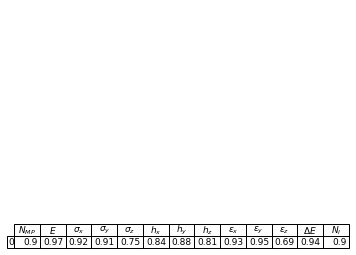

In [18]:
from pandas.plotting import table # EDIT: see deprecation warnings below

ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, r2_adj)  # where df is your data frame

plt.savefig(f'{plot_dir}/r2_adj_fw.png')

In [20]:
#error = qoi_pred_plot - qoi_test_plot

In [22]:
rel_error = (qoi_pred_plot - qoi_test_plot) / qoi_test_plot * 100.
rel_error = pd.DataFrame(rel_error, columns=qoi_test_plot.columns).abs()

In [23]:
rel_error_table = np.round(rel_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}, columns=qoi_labels), decimals=2)

In [24]:
rel_error_table

$N_{MP}$   $E$  $\sigma_x$  $\sigma_y$  $\sigma_z$  $h_x$  $h_y$  $h_z$  \
50%      0.82  0.02        1.07        1.01        1.37   2.52   2.34   2.16   
75%      1.40  0.03        1.86        1.82        2.34   4.32   4.23   3.87   
90%      1.97  0.06        2.74        2.92        3.33   6.24   6.36   5.66   
95%      2.36  0.07        3.23        3.54        4.08   7.40   7.80   6.69   
99%      3.19  0.12        4.66        4.61        5.26   9.89  10.62   8.96   

     $\epsilon_x$  $\epsilon_y$  $\epsilon_z$  $\Delta E$  $N_l$  
50%          2.28          2.03          2.11        1.28   2.72  
75%          4.04          3.34          3.51        2.32   4.82  
90%          6.08          4.96          5.12        3.44   6.90  
95%          7.58          6.31          6.29        4.35   8.08  
99%         10.98          9.16          8.89        6.13  10.21

## Plot

### Relative Errors

In [25]:
rel_error_table1 = rel_error_table.drop(columns = "$N_{MP}$")

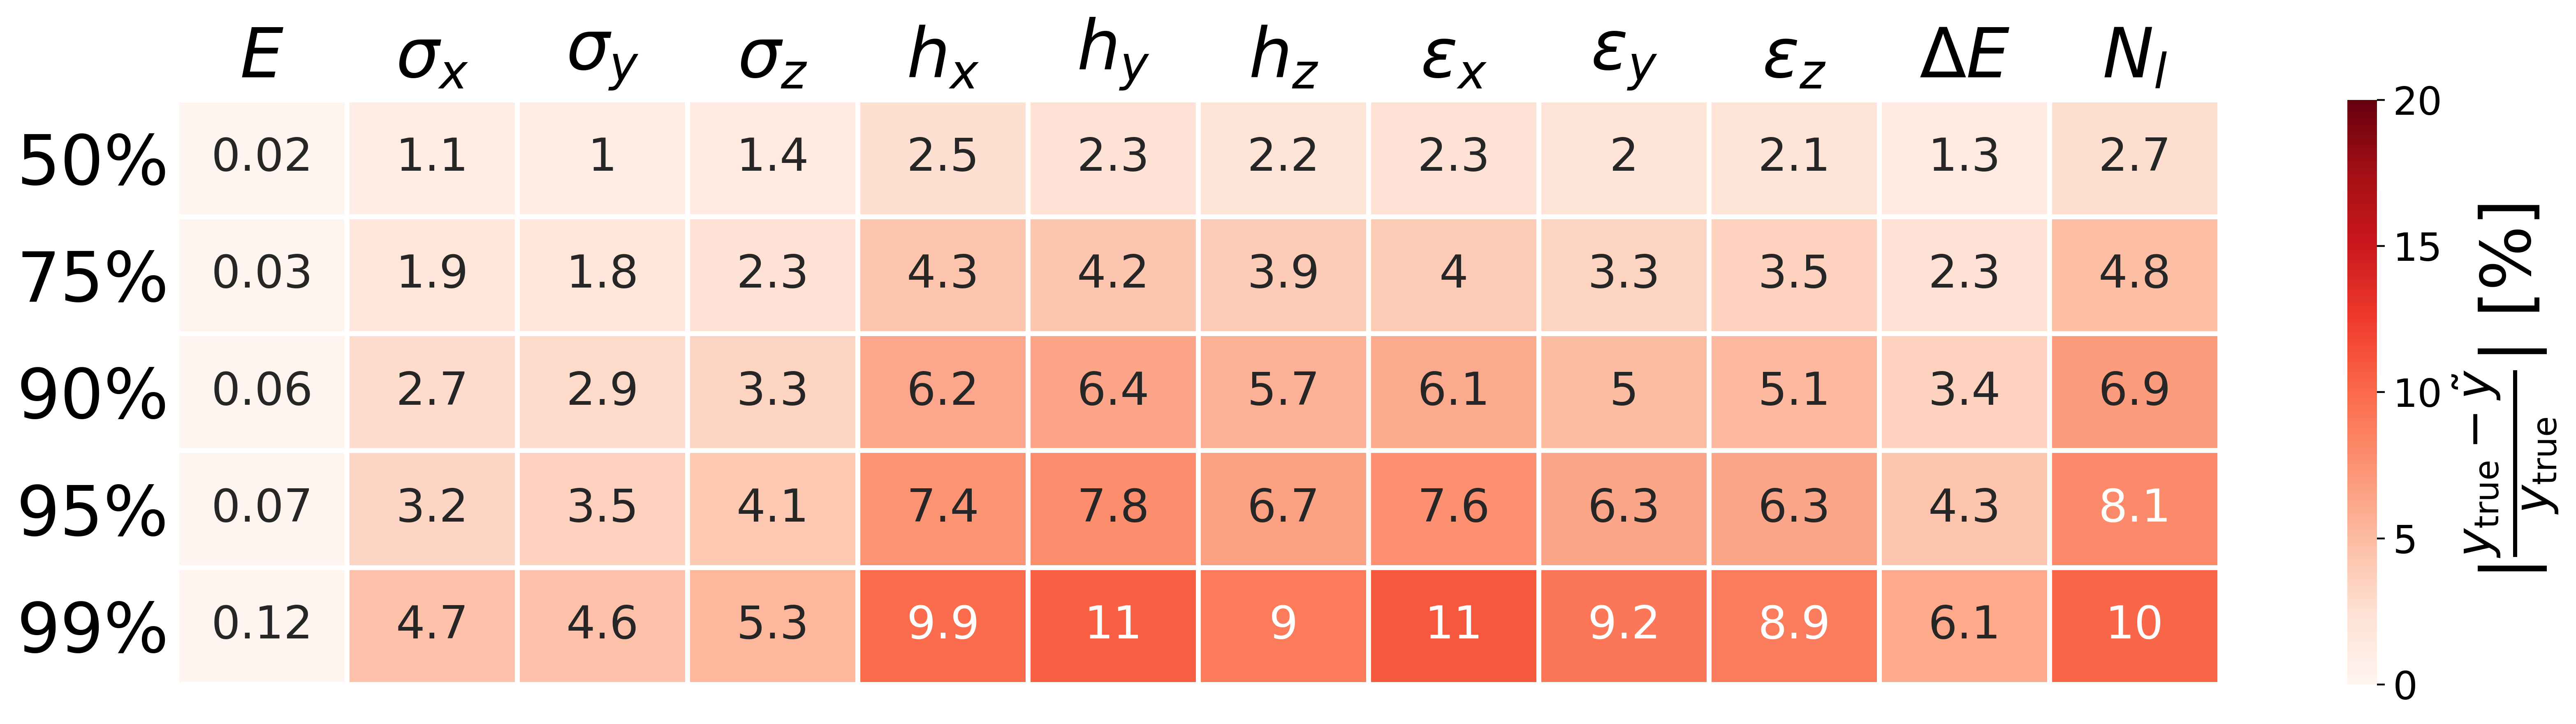

In [26]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table1,
            cmap='Reds',
            annot=True,
            linewidths=2.,
            vmin=0.,
            vmax=20.,
            annot_kws={'fontsize': 20},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=30, length=0)
ax.tick_params(axis='y', rotation=0)
ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/isodar_forward_rel_error_percentiles.jpg')

# Inverse Prediction

## Predict

In [28]:
all_r2_adj = []

for n_tries in [32]:
    dvar_pred = surr.sample_n_tries(qoi_test.values, batch_size=8, n_tries=n_tries)
    qoi_pred = val_surr.predict(dvar_pred)
    qoi_pred = pd.DataFrame(data=qoi_pred, columns=qoi_test.columns)
    
    metric = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

    qoi_pred_plot = qoi_pred.copy()
    qoi_pred_plot['particle_losses']=2e4-qoi_pred_plot['Number of Macro Particles']
    
    r2_adj = metric.call(qoi_test_plot.values, qoi_pred_plot.values).numpy()
    r2_adj = pd.Series(data=r2_adj, index=qoi_test_plot.columns)
    r2_adj = np.round(r2_adj, decimals=2)
    r2_adj = pd.DataFrame(r2_adj).T.rename(columns=qoi_labels)
    
    r2_adj['n_tries'] = n_tries
    all_r2_adj.append(r2_adj)

all_r2_adj = pd.concat(all_r2_adj, ignore_index=True)

## Calculate metrics

In [29]:
all_r2_adj

$N_{MP}$   $E$  $\sigma_x$  $\sigma_y$  $\sigma_z$  $h_x$  $h_y$  $h_z$  \
0      0.79  0.96        0.94        0.87        0.77   0.83   0.82   0.78   

   $\epsilon_x$  $\epsilon_y$  $\epsilon_z$  $\Delta E$  $N_l$  n_tries  
0          0.91          0.91          0.66        0.91   0.79       32

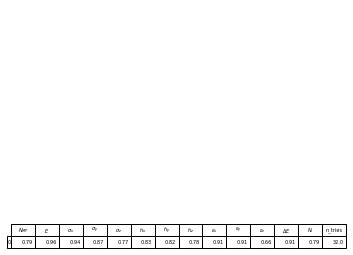

In [30]:
ax = plt.subplot(111, frame_on=False) # no visible frame
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, all_r2_adj)  # where df is your data frame

plt.savefig(f'{plot_dir}/all_r2_adj_iv.png')


In [32]:
#error = qoi_pred_plot - qoi_test_plot

In [33]:
rel_error = (qoi_pred_plot - qoi_test_plot) / qoi_test_plot * 100.
rel_error = pd.DataFrame(rel_error, columns=qoi_test_plot.columns).abs()

In [34]:
rel_error_table = np.round(rel_error.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}, columns=qoi_labels), decimals=2)

In [35]:
rel_error_table

$N_{MP}$   $E$  $\sigma_x$  $\sigma_y$  $\sigma_z$  $h_x$  $h_y$  $h_z$  \
50%      0.96  0.03        0.98        0.98        1.24   2.10   2.16   1.83   
75%      1.75  0.04        1.64        1.75        2.11   3.88   4.10   3.63   
90%      2.74  0.07        2.39        3.02        3.20   6.00   7.55   5.61   
95%      3.57  0.09        3.00        4.05        4.16   7.94  10.14   7.28   
99%      6.04  0.12        4.36        6.31        6.00  12.84  15.52  11.80   

     $\epsilon_x$  $\epsilon_y$  $\epsilon_z$  $\Delta E$  $N_l$  
50%          1.93          2.14          1.81        1.40   3.35  
75%          3.96          3.79          3.04        2.60   5.87  
90%          6.68          7.07          5.10        4.03   8.69  
95%          8.27          9.12          6.79        5.31  10.96  
99%         13.60         13.69         11.55        9.47  16.20

### Relative Errors

In [36]:
rel_error_table1 = rel_error_table.drop(columns = "$N_{MP}$")

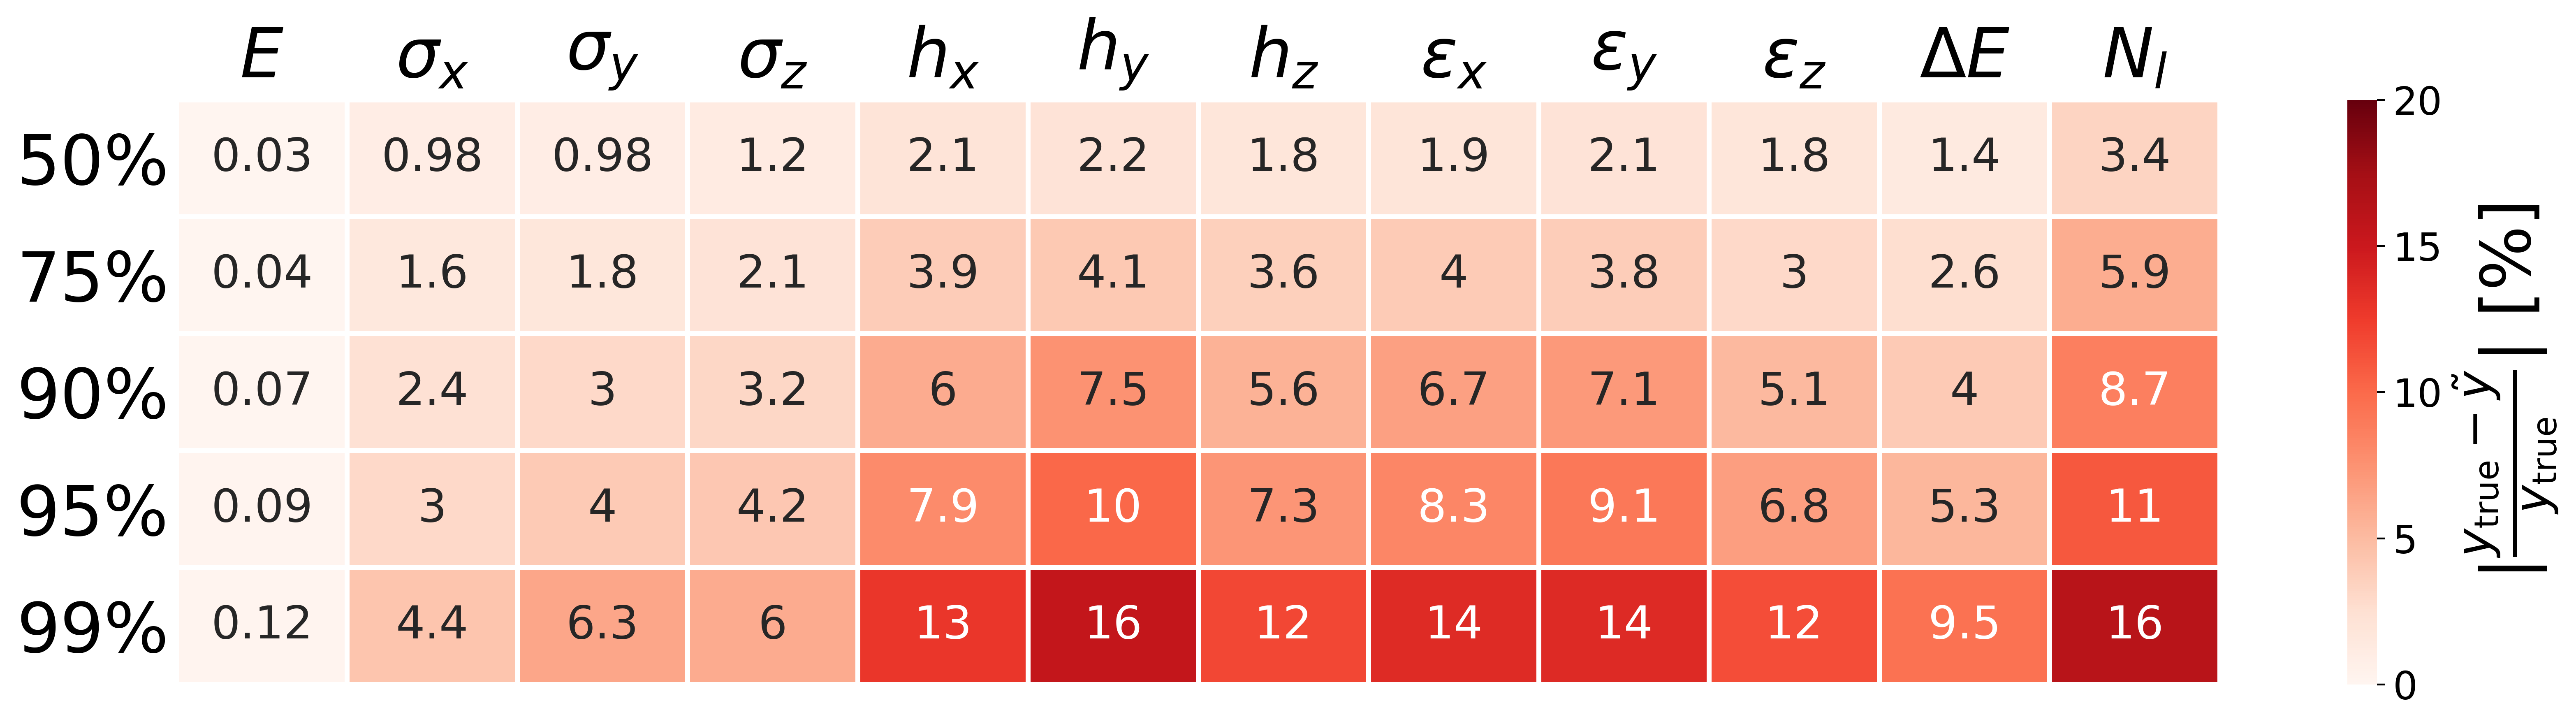

In [37]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table1,
            cmap='Reds',
            annot=True,
            linewidths=2.,
            vmin=0.,
            vmax=20.,
            annot_kws={'fontsize': 20},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=30, length=0)
ax.tick_params(axis='y', rotation=0)
ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/isodar_invertible_sampling_rel_error_percentiles.jpg')

In [38]:
surr.model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
affine_coupling_block (Affin (None, 14)                18268     
_________________________________________________________________
permutation_layer (Permutati (None, 14)                0         
_________________________________________________________________
affine_coupling_block_1 (Aff (None, 14)                18268     
_________________________________________________________________
permutation_layer_1 (Permuta (None, 14)                0         
_________________________________________________________________
affine_coupling_block_2 (Aff (None, 14)                18268     
_________________________________________________________________
permutation_layer_2 (Permuta (None, 14)               